In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
!nvidia-smi
!nvcc --version

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
project_path = '/content/gdrive/MyDrive/madeira'
images_path = f'{project_path}'

In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import datetime
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("train_coco", {}, f"{images_path}/train_coco/annotations.json", f'{images_path}/train_coco')
train_dataset = DatasetCatalog.get("train_coco")
train_metadata = MetadataCatalog.get("train_coco")

register_coco_instances("test_coco", {}, f"{images_path}/test_coco/annotations.json", f'{images_path}/test_coco')
test_dataset = DatasetCatalog.get("test_coco")
test_metadata = MetadataCatalog.get("test_coco")

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.RandomBrightness(0.9, 1.1),
        T.RandomContrast(0.9, 1.1),
        T.RandomSaturation(0.9, 1.1),
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomCrop("relative", (0.4, 0.4))
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
# If first training

cfg = get_cfg()

cfg.OUTPUT_DIR = f'{project_path}/model/best'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("train_coco",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = (300)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)

trainer = AugTrainer(cfg)
checkpointer = DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)

In [ ]:
# Train

import os

cfg.SOLVER.MAX_ITER = (300)
trainer.resume_or_load(resume=False)
trainer.resume_or_load()
trainer.train()

['_background_', 'base']


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


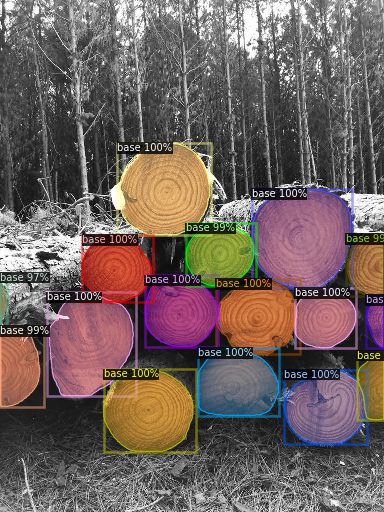

In [19]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
#im = cv2.imread(f'{images_path}/de frente.jpeg')
im = cv2.imread(f'{images_path}/test_coco/JPEGImages/1_3.jpg')
print(test_metadata.thing_classes)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=train_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])